In [1]:
from sklearn.datasets import make_moons, make_classification, make_circles, make_blobs
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
from itertools import cycle, islice
import matplotlib
import warnings
from matplotlib.ticker import MaxNLocator
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 20})

In [2]:
###Generate data for Binary Classification
def get_data(random_seed):
    np.random.seed(random_seed) 
    X,y = make_blobs(n_samples=150, centers=2, cluster_std=0.7)
    X[:,0] -= 9.3
    X[:,1] -= 2.5

    np.random.seed(1)
    pos_ids = np.where(y == 0)[0]
    neg_ids = np.where(y == 1)[0]
    ids1 = np.random.randint(0,len(pos_ids),5)
    ids2 = np.random.randint(0,len(neg_ids),5)
    p1 = pos_ids[ids1]
    p2 = neg_ids[ids2]

    ## generate labeled and unlabeled data
    l_ids = np.concatenate((p1 , p2))
    u_ids = np.array(list(set(np.arange(X.shape[0])) - set(l_ids)))
    l_data1, l_data2 = X[l_ids,0].reshape(-1,1), X[l_ids,1].reshape(-1,1)
    u_data1, u_data2 = X[u_ids,0].reshape(-1,1), X[u_ids,1].reshape(-1,1)
    labels = y[l_ids]
    return [l_data1, l_data2], [u_data1, u_data2], labels, X, y, [p1, p2]


In [197]:
from sklearn.ensemble import RandomForestClassifier

def update_train(sel_ids, train_data, train_labels, untrain_data, pred_y):
    add_ids = np.where(np.array(sel_ids) != 0)[0]
    add_data = [d[add_ids] for d in untrain_data]
    new_train_data = [np.concatenate([d1, d2]) for d1,d2 in zip(train_data, add_data)]
    add_y = pred_y[add_ids]
    new_train_y = np.concatenate([train_labels, pred_y[add_ids]])
    return new_train_data, new_train_y

def get_lambda_class(pred_prob, pred_y, y_train, max_add):
    y = y_train
    lambdas = np.zeros(pred_prob.shape[1])
    add_ids = np.zeros(pred_prob.shape[0])
    clss = np.unique(y)
    assert pred_prob.shape[1] == len(clss)
    ratio_per_class = [sum(y == c)/len(y) for c in clss]
    for cls in range(len(clss)):
        indices = np.where(pred_y == cls)[0]
        if len(indices) == 0:
            continue
        cls_score = pred_prob[indices, cls]
        idx_sort = np.argsort(cls_score)
        add_num = min(int(np.ceil(ratio_per_class[cls] * max_add)),
                      indices.shape[0])
        add_ids[indices[idx_sort[-add_num:]]] = 1
        lambdas[cls] = cls_score[idx_sort[-add_num]] - 0.1
    return add_ids.astype('bool'), lambdas

def get_ids_weights(pred_prob, pred_y, y_train, max_add, gamma, regularizer='hard'):
    '''
    pred_prob: predicted probability of all views on untrain data
    pred_y: predicted label for untrain data
    train_data: training data
    max_add: number of selected data
    gamma: view correlation hyper-parameter
    '''
    #print('Getting Lambdas')
    add_ids, lambdas = get_lambda_class(pred_prob, pred_y, y_train, max_add)
    #print('Getting Weights')
    weight = np.array([(pred_prob[i, l] - lambdas[l]) / (gamma + 1e-5)
                       for i, l in enumerate(pred_y)],
                      dtype='float32')
    weight[~add_ids] = 0
    if regularizer == 'hard' or gamma == 0:
        weight[add_ids] = 1
        #print(f'Returning Weights {weight}')
        return add_ids, weight
    weight[weight < 0] = 0
    weight[weight > 1] = 1
    #print(f'Returning Weights {weight}')
    return add_ids, weight

def update_ids_weights(view, probs, sel_ids, weights, pred_y, train_data,
                       max_add, gamma, regularizer='hard'):
    num_view = len(probs)
    for v in range(num_view):
        if v == view:
            continue
        ov = sel_ids[v]
        probs[view][ov, pred_y[ov]] += gamma * weights[v][ov] / (num_view-1)
    sel_id, weight = get_ids_weights(probs[view], pred_y, train_data,
                                     max_add, gamma, regularizer)
    return sel_id, weight

def spaco(l_data, lbls, u_data, iter_step = 1, gamma = 0.5, num_view=2, add_num= 6, regularizer='hard'):
    
    # initiate classifier
    clfs = []
    scores = []
    add_num = add_num
    update_add_num = add_num
    sel_ids = []
    weights = []

    print('Intiating first classifiers and predictions')
    for view in range(num_view):
        clfs.append(RandomForestClassifier())
        clfs[view].fit(l_data[view], lbls)
        scores.append(clfs[view].predict_proba(u_data[view]))
        #add_ids.append(sel_ids_y(scores[view], add_num))
        pred_y = np.argmax(sum(scores), axis = 1)
    
    # initiate weights for unlabled examples
    print('Initiating weights for unlabeled examples')
    for view in range(num_view):
        sel_id, weight = get_ids_weights(scores[view], pred_y,
                                            lbls, add_num, gamma,
                                            regularizer)
        sel_ids.append(sel_id)
        weights.append(weight)
    
    print(f'Running {iter_step} steps')
    pred_y = np.argmax(sum(scores), axis = 1)
    for step in range(iter_step):
        for view in range(2):
            
            # Update v
            sel_ids[view], weights[view] = update_ids_weights(
                view,
                scores,
                sel_ids,
                weights,
                pred_y,
                lbls,
                add_num,
                gamma,
                regularizer
            )
                             
            #update w
            nl_data, nlbls = update_train(sel_ids[view], l_data, lbls, u_data, pred_y)
            clfs[view].fit(nl_data[view], nlbls)
            #print(f'Train data size: {len(nl_data[0])}')
            
            add_num += update_add_num
            # udpate sample weights
            sel_ids[view], weights[view] = update_ids_weights(
                view,
                scores,
                sel_ids,
                weights,
                pred_y,
                lbls,
                add_num,
                gamma,
                regularizer
            )
            
            pred_y = np.argmax(sum(scores), axis = 1)
            
        if len(nl_data[0]) >= len(u_data[0]): break
    return clfs

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 16 steps
Train data size: 16
Train data size: 22
Train data size: 28
Train data size: 34
Train data size: 40
Train data size: 46
Train data size: 52
Train data size: 58
Train data size: 64
Train data size: 70
Train data size: 76
Train data size: 82
Train data size: 88
Train data size: 94
Train data size: 100
Train data size: 106
Train data size: 112
Train data size: 118
Train data size: 124
Train data size: 130
Train data size: 136
Train data size: 142
spaco experiment(gamma=3): 0.97333
Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 16 steps
Train data size: 16
Train data size: 22
Train data size: 28
Train data size: 34
Train data size: 40
Train data size: 46
Train data size: 52
Train data size: 58
Train data size: 64
Train data size: 70
Train data size: 76
Train data size: 82
Train data size: 88
Train data size: 94
Train data size: 100
Train data

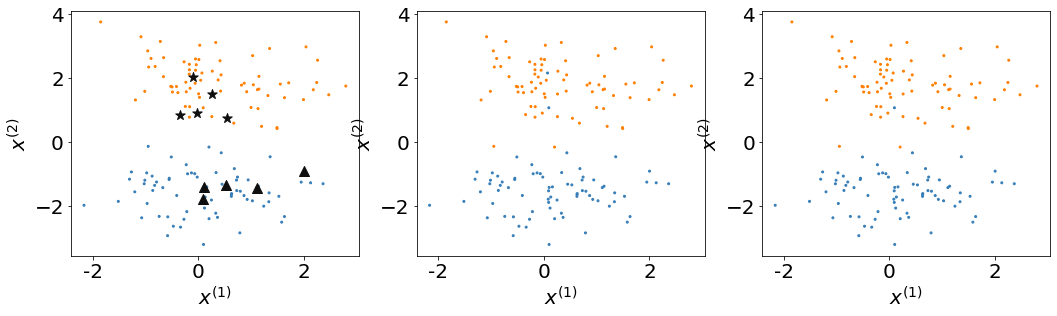

In [171]:
x = [-1.5,0,1.5]
my_xticks=[-2,0,2]

### Get data
ldata, udata, labels, X, y, label_ids = get_data(4)

### parameters
steps = 16
gamma = 3

### original fig
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 3))))
fig = plt.figure(figsize=(16,4))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=0.9)

ax = fig.add_subplot(131)
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[y], s=4)
plt.scatter(X[label_ids[0],0], X[label_ids[0],1], marker='^', c='#0F0F0F', s=100)
plt.scatter(X[label_ids[1],0], X[label_ids[1],1], marker='*', c='#0F0F0F', s=100)
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.xticks(x, my_xticks)
     
    
#### spaco experiment1 gamma=3
clfs = spaco(ldata, labels, udata, iter_step=steps, gamma=3)
score1 = clfs[0].predict_proba(X[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)
print('spaco experiment(gamma=3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(132)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)


#### spaco experiment2 gamma=0.3
clfs = spaco(ldata, labels, udata, iter_step=steps, gamma=0.3, regularizer='soft')
score1 = clfs[0].predict_proba(X[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)
print('spaco experiment(gamma=0.3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(133)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)

plt.show()

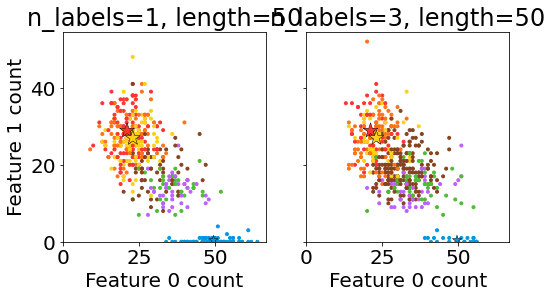

The data was generated from (random_state=4):
Class	P(C)	P(w0|C)	P(w1|C)
red	0.39	0.42	0.58
blue	0.22	0.99	0.01
yellow	0.39	0.46	0.54


In [113]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_multilabel_classification as make_ml_clf

COLORS = np.array(
    [
        "!",
        "#FF3333",  # red
        "#0198E1",  # blue
        "#BF5FFF",  # purple
        "#FCD116",  # yellow
        "#FF7216",  # orange
        "#4DBD33",  # green
        "#87421F",  # brown
    ]
)

# Use same random seed for multiple calls to make_multilabel_classification to
# ensure same distributions
RANDOM_SEED = 4


def plot_2d(ax, n_labels=1, n_classes=3, length=50):
    X, Y, p_c, p_w_c = make_ml_clf(
        n_samples=500,
        n_features=2,
        n_classes=n_classes,
        n_labels=n_labels,
        length=length,
        allow_unlabeled=False,
        return_distributions=True,
        random_state=RANDOM_SEED,
    )

    ax.scatter(
        X[:, 0], X[:, 1], color=COLORS.take((Y * [1, 2, 4]).sum(axis=1)), marker="."
    )
    ax.scatter(
        p_w_c[0] * length,
        p_w_c[1] * length,
        marker="*",
        linewidth=0.5,
        edgecolor="black",
        s=20 + 1500 * p_c ** 2,
        color=COLORS.take([1, 2, 4]),
    )
    ax.set_xlabel("Feature 0 count")
    return p_c, p_w_c


_, (ax1, ax2) = plt.subplots(1, 2, sharex="row", sharey="row", figsize=(8, 4))
plt.subplots_adjust(bottom=0.15)

p_c, p_w_c = plot_2d(ax1, n_labels=1)
ax1.set_title("n_labels=1, length=50")
ax1.set_ylabel("Feature 1 count")

plot_2d(ax2, n_labels=3)
ax2.set_title("n_labels=3, length=50")
ax2.set_xlim(left=0, auto=True)
ax2.set_ylim(bottom=0, auto=True)

plt.show()

print("The data was generated from (random_state=%d):" % RANDOM_SEED)
print("Class", "P(C)", "P(w0|C)", "P(w1|C)", sep="\t")
for k, p, p_w in zip(["red", "blue", "yellow"], p_c, p_w_c.T):
    print("%s\t%0.2f\t%0.2f\t%0.2f" % (k, p, p_w[0], p_w[1]))

In [11]:
def get_data(n_samples=150, n_features=2, n_classes=3, n_labels=1, length=50, random_seed=4):
    X, Y, p_c, p_w_c = make_ml_clf(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_labels=n_labels,
        length=length,
        allow_unlabeled=False,
        return_distributions=True,
        random_state=random_seed,
    )

    return X, Y, p_c, p_w_c

In [12]:
from sklearn.datasets import make_classification
def get_data(n_samples=150, n_features=2, n_classes=3, n_labels=1, length=50, random_seed=4):
    X, Y, p_c, p_w_c = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_labels=n_labels,
        length=length,
        allow_unlabeled=False,
        return_distributions=True,
        random_state=random_seed,
    )

    return X, Y, p_c, p_w_c

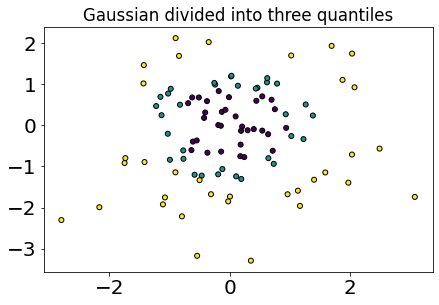

In [104]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles

plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
X1, Y1 = make_gaussian_quantiles(n_features=2, n_classes=3)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

plt.show()



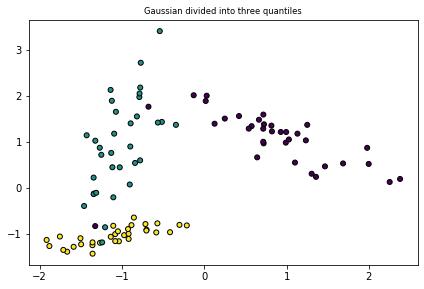

0.93

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)

plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

plt.show()

x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.90, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_pred = rfc.predict(X1)
accuracy_score(rfc_pred, Y1)

RFC accuracy with 120 labeled data 0.995


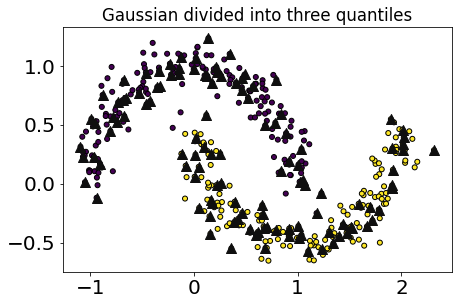

In [206]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X1, Y1 = make_moons(
    n_samples=400,
    shuffle=True,
    noise=.1
)
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.70, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_pred = rfc.predict(X1)
print(f'RFC accuracy with {len(x_train)} labeled data {accuracy_score(rfc_pred, Y1)}')

plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=rfc_pred, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 20 steps
SPAMCO accuracy with (gamma=3) 120 labeled data 0.9375


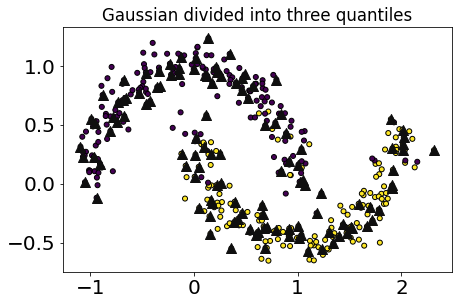

In [207]:
#### spaco experiment2 gamma=0.3
### parameters
steps = 20
gamma = 3

ldata = [
    x_train[:,0].reshape(-1,1),
    x_train[:,1].reshape(-1,1)
    ]
udata = [
    x_test[:,0].reshape(-1,1),
    x_test[:,1].reshape(-1,1)
    ]

clfs = spaco(ldata, y_train, udata, iter_step=steps, gamma=gamma, regularizer='soft')
score1 = clfs[0].predict_proba(X1[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X1[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)

print(f'SPAMCO accuracy with (gamma={gamma}) {len(x_train)} labeled data {accuracy_score(pred_y, Y1)}')
plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=pred_y, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

RFC accuracy with 10 labeled data 0.83


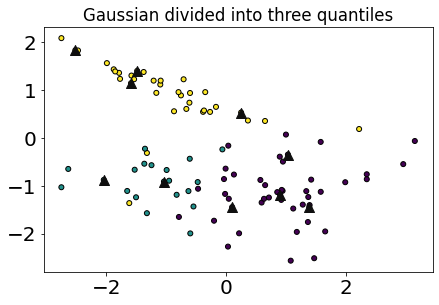

In [220]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.datasets import make_gaussian_quantiles


X1, Y1 = make_classification(
    n_features=4, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.90, random_state=42)
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_pred = rfc.predict(X1)
print(f'RFC accuracy with {len(x_train)} labeled data {accuracy_score(rfc_pred, Y1)}')

plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=rfc_pred, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 20 steps
SPAMCO accuracy with (gamma=0.3) 10 labeled data 0.69


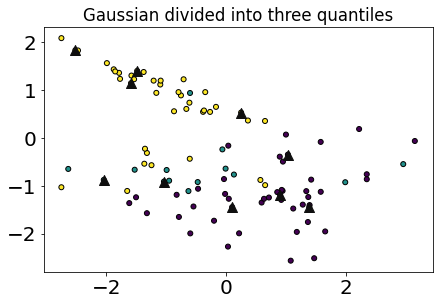

In [227]:
#### spaco experiment2 gamma=0.3
### parameters
steps = 20
gamma = .3

ldata = [
    x_train[:,0].reshape(-1,1),
    x_train[:,1].reshape(-1,1),
    x_train[:,2].reshape(-1,1),
    x_train[:,3].reshape(-1,1)
    ]
udata = [
    x_test[:,0].reshape(-1,1),
    x_test[:,1].reshape(-1,1),
    x_test[:,2].reshape(-1,1),
    x_test[:,3].reshape(-1,1)
    ]

clfs = spaco(ldata, y_train, udata, iter_step=steps, gamma=gamma, regularizer='soft', num_view=4)
score1 = clfs[0].predict_proba(X1[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X1[:,1].reshape(-1,1))
score3 = clfs[2].predict_proba(X1[:,2].reshape(-1,1))
score4 = clfs[3].predict_proba(X1[:,3].reshape(-1,1))
score = score1 + score2 + score3 + score4
pred_y = np.argmax(score, axis = 1)

print(f'SPAMCO accuracy with (gamma={gamma}) {len(x_train)} labeled data {accuracy_score(pred_y, Y1)}')
plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=pred_y, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

In [218]:
score

array([[0.11, 3.83, 0.06],
       [0.06, 3.16, 0.78],
       [0.22, 3.65, 0.13],
       [0.11, 3.58, 0.31],
       [0.66, 3.21, 0.13],
       [0.28, 3.45, 0.27],
       [0.7 , 1.36, 1.94],
       [0.7 , 2.56, 0.74],
       [0.66, 3.28, 0.06],
       [0.06, 3.17, 0.77],
       [0.66, 3.28, 0.06],
       [0.06, 1.29, 2.65],
       [0.75, 3.19, 0.06],
       [0.06, 3.2 , 0.74],
       [0.11, 3.69, 0.2 ],
       [0.66, 3.21, 0.13],
       [0.11, 3.83, 0.06],
       [0.7 , 1.35, 1.95],
       [0.06, 3.2 , 0.74],
       [0.22, 3.51, 0.27],
       [0.11, 3.69, 0.2 ],
       [0.11, 3.83, 0.06],
       [0.66, 3.26, 0.08],
       [0.66, 3.11, 0.23],
       [0.75, 3.18, 0.07],
       [0.86, 3.01, 0.13],
       [0.66, 3.17, 0.17],
       [0.11, 3.66, 0.23],
       [0.11, 3.23, 0.66],
       [0.06, 2.87, 1.07],
       [0.06, 3.05, 0.89],
       [0.66, 3.04, 0.3 ],
       [0.7 , 1.58, 1.72],
       [0.11, 3.66, 0.23],
       [0.06, 3.06, 0.88],
       [0.11, 3.83, 0.06],
       [0.14, 2.04, 1.82],
 

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 20 steps
SPAMCO accuracy with (gamma=0.3) 5 labeled data 0.47


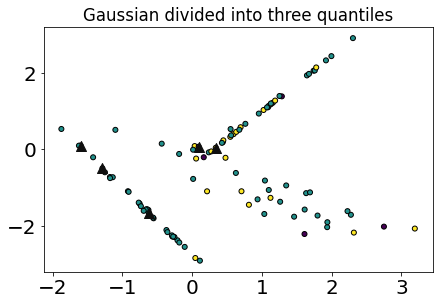

In [211]:
#### spaco experiment2 gamma=0.3
### parameters
steps = 20
gamma = .3

ldata = [
    x_train,
    x_train
    ]
udata = [
    x_test,
    x_test
    ]

clfs = spaco(ldata, y_train, udata, iter_step=steps, gamma=gamma, regularizer='soft', num_view=2)
pred_y = clfs[0].predict(X1)

print(f'SPAMCO accuracy with (gamma={gamma}) {len(x_train)} labeled data {accuracy_score(pred_y, Y1)}')
plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=pred_y, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()